In [1]:
!nvidia-smi

Wed Jun 21 15:38:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [4]:
class_names = ['withNP', 'withoutNP']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [5]:
def load_data():

    datasets = ['/content/gdrive/MyDrive/data/train', '/content/gdrive/MyDrive/data/test']
    output = []

    # train ve test verileri set edilir
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # her bir sınıfa karşılık gelen klasörü yenile
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # klasördeki her görüntüyü tekrar et
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # resmin pathi alınır
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # goruntu boyutlandırma islemi
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # görüntüyü ve o görüntüye ait etiket dizilere eklenir
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()


Loading /content/gdrive/MyDrive/data/train


100%|██████████| 120/120 [00:01<00:00, 84.10it/s] 


Loading /content/gdrive/MyDrive/data/test


100%|██████████| 30/30 [00:05<00:00,  5.86it/s]


In [7]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 240
Number of testing examples: 60
Each image is of size: (150, 150)


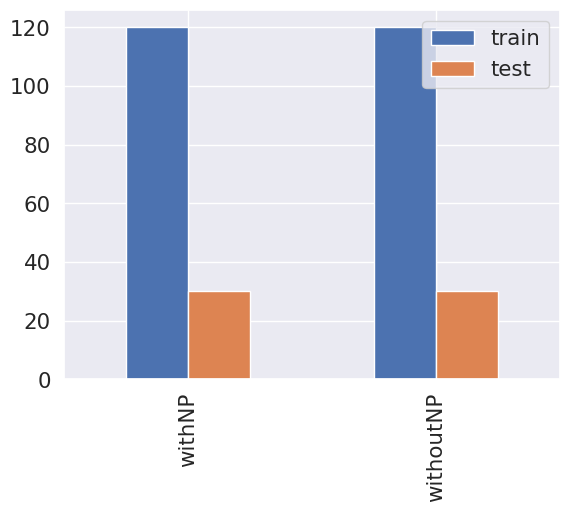

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [11]:
def display_random_image(class_names, images, labels):

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

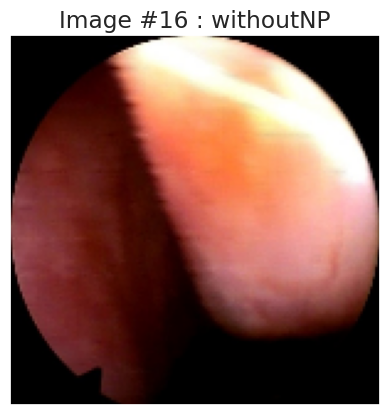

In [12]:
display_random_image(class_names, train_images, train_labels)


In [13]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

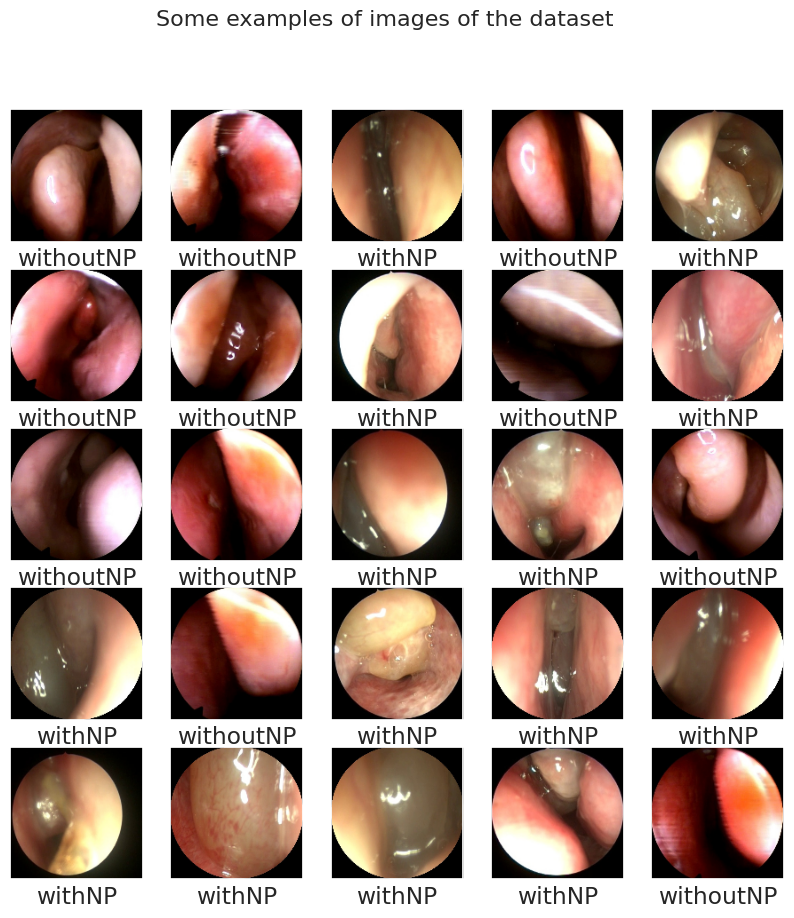

In [14]:
display_examples(class_names, train_images, train_labels)


In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

In [16]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_images, train_labels, batch_size=16, epochs=7, validation_split = 0.2)

Epoch 1/7
12/12 [==============================] - 13s 33ms/step - loss: 0.6814 - accuracy: 0.5573 - val_loss: 0.6716 - val_accuracy: 0.5208
Epoch 2/7
12/12 [==============================] - 0s 15ms/step - loss: 0.5145 - accuracy: 0.8177 - val_loss: 0.5295 - val_accuracy: 0.7292
Epoch 3/7
12/12 [==============================] - 0s 14ms/step - loss: 0.3211 - accuracy: 0.9115 - val_loss: 0.4067 - val_accuracy: 0.8125
Epoch 4/7
12/12 [==============================] - 0s 12ms/step - loss: 0.2133 - accuracy: 0.9323 - val_loss: 0.3338 - val_accuracy: 0.8750
Epoch 5/7
12/12 [==============================] - 0s 12ms/step - loss: 0.1368 - accuracy: 0.9531 - val_loss: 0.2793 - val_accuracy: 0.8958
Epoch 6/7
12/12 [==============================] - 0s 12ms/step - loss: 0.0761 - accuracy: 0.9948 - val_loss: 0.2058 - val_accuracy: 0.9167
Epoch 7/7
12/12 [==============================] - 0s 11ms/step - loss: 0.0493 - accuracy: 0.9948 - val_loss: 0.1770 - val_accuracy: 0.9167


In [18]:
model.save('/content/gdrive/MyDrive/data/kerasModel.h5')

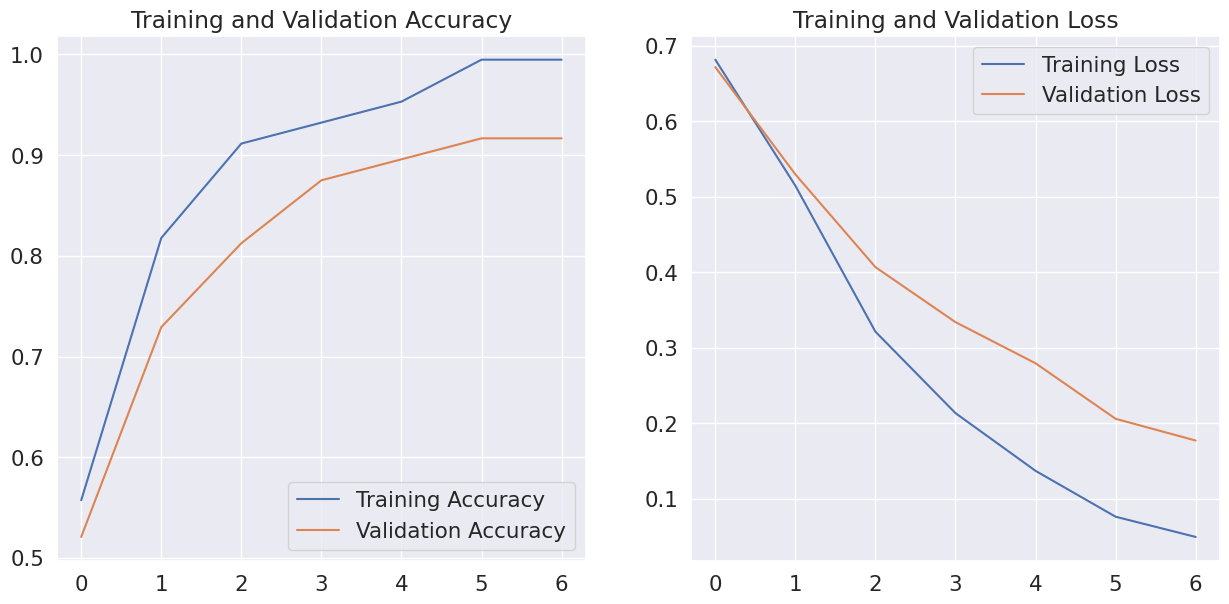

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
test_loss = model.evaluate(test_images, test_labels)

2/2 [==============================] - 1s 131ms/step - loss: 0.0540 - accuracy: 0.9833


2/2 [==============================] - 0s 6ms/step


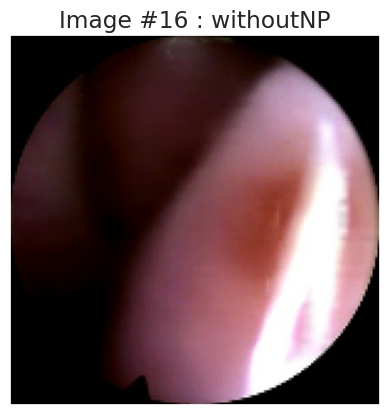

In [23]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability



display_random_image(class_names, test_images, pred_labels)

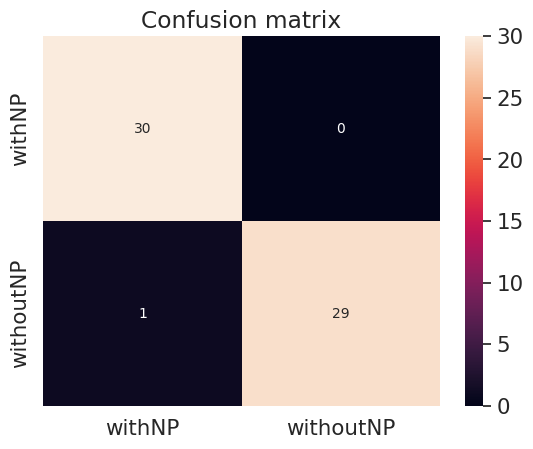

In [24]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [25]:
laabels=['withNP','withoutNP']

In [26]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_labels, pred_labels,target_names=laabels))



              precision    recall  f1-score   support

      withNP       0.97      1.00      0.98        30
   withoutNP       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

